# LangGraph 챗봇 구축

먼저 `LangGraph`를 사용하여 간단한 챗봇을 만들어 보겠습니다. 이 챗봇은 사용자 메시지에 직접 응답할 것입니다. 비록 간단하지만, `LangGraph`로 구축하는 핵심 개념을 설명할 것입니다. 이 섹션이 끝나면 기본적인 챗봇을 구축하게 될 것입니다.

`StateGraph`를 생성하는 것으로 시작하십시오. `StateGraph` 객체는 챗봇의 구조를 "상태 기계(State Machine)"로 정의합니다. 

`nodes`를 추가하여 챗봇이 호출할 수 있는 `llm`과 함수들을 나타내고, `edges`를 추가하여 봇이 이러한 함수들 간에 어떻게 전환해야 하는지를 지정합니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## Step-by-Step 개념 이해하기!

### STEP 1. 상태(State) 정의

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]

### STEP 2. 노드(Node) 정의

다음으로 "`chatbot`" 노드를 추가합니다. 

노드는 작업의 단위를 나타내며, 일반적으로 정규 **Python** 함수입니다.

In [4]:
from langchain_openai import ChatOpenAI

# LLM 정의
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)


# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}

### STEP 3. 그래프(Graph) 정의, 노드 추가

In [5]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

**참고**

- `chatbot` 노드 함수는 현재 `State`를 입력으로 받아 "messages"라는 키 아래에 업데이트된 `messages` 목록을 포함하는 사전(TypedDict) 을 반환합니다. 

- `State`의 `add_messages` 함수는 이미 상태에 있는 메시지에 llm의 응답 메시지를 추가합니다. 

### STEP 4. 그래프 엣지(Edge) 추가

다음으로, `START` 지점을 추가하세요. `START`는 그래프가 실행될 때마다 **작업을 시작할 위치** 입니다.

In [6]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")


마찬가지로, `END` 지점을 설정하십시오. 이는 그래프 흐름의 종료(끝지점) 를 나타냅니다.

In [7]:
# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

### STEP 5. 그래프 컴파일(compile)

마지막으로, 그래프를 실행할 수 있어야 합니다. 이를 위해 그래프 빌더에서 "`compile()`"을 호출합니다. 이렇게 하면 상태에서 호출할 수 있는 "`CompiledGraph`"가 생성됩니다.

In [8]:
# 그래프 컴파일
graph = graph_builder.compile()

### STEP 6. 그래프 시각화

이제 그래프를 시각화해봅시다.

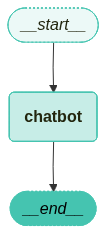

In [9]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

### STEP 7. 그래프 실행

이제 챗봇을 실행해봅시다!

In [10]:
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 물론입니다! 서울에서 인기 있고 맛있는 맛집 TOP 10을 추천드릴게요.

1. **광장시장 빈대떡집**  
   - 전통 빈대떡과 다양한 한식 간식을 즐길 수 있는 곳입니다.

2. **광장시장 육회골목**  
   - 신선한 육회와 다양한 한식 메뉴를 맛볼 수 있는 곳입니다.

3. **광장시장 김밥천국**  
   - 저렴하고 맛있는 김밥과 분식류를 즐기실 수 있어요.

4. **명동 교자**  
   - 만두와 칼국수로 유명한 명동 대표 맛집입니다.

5. **이태원 브루클린 더 버거 조인트**  
   - 미국식 수제버거를 맛볼 수 있는 인기 장소입니다.

6. **강남역 미우새**  
   - 고급 한우와 다양한 한식을 즐길 수 있는 곳입니다.

7. **홍대 연남동 맛집 골목**  
   - 다양한 카페와 맛집이 모여 있는 트렌디한 지역입니다.

8. **종로 육회집**  
   - 신선한 육회와 한우 요리를 즐길 수 있는 곳입니다.

9. **신사동 가로수길 카페거리**  
   - 세련된 카페와 디저트 맛집들이 모여 있어 커피와 디저트를 즐기기 좋아요.

10. **잠실 롯데월드몰 내 맛집**  
    - 다양한 글로벌 레스토랑과 푸드코트가 있어 쇼핑과 함께 맛집 탐방이 가능합니다.

이 외에도 서울에는 수많은 맛집이 있으니, 방문하실 지역과 취향에 맞게 선택하시면 좋을 것 같아요! 즐거운 식사 되시길 바랍니다.


자! 여기까지가 가장 기본적인 챗봇 구축이었습니다. 

아래는 이전 과정을 정리한 전체 코드입니다.

## 전체 코드

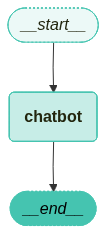

물론입니다! 서울에서 인기 있고 맛있는 맛집 TOP 10을 추천드릴게요.

1. **광장시장 빈대떡집**  
   - 대표 메뉴: 빈대떡, 마약김밥  
   - 특징: 전통 시장에서 즐기는 한국 전통 전과 간단한 길거리 음식

2. **광장시장 육회집**  
   - 대표 메뉴: 육회, 육회비빔밥  
   - 특징: 신선한 육회와 다양한 한식 메뉴를 즐길 수 있는 곳

3. **광장시장 쌈밥집**  
   - 대표 메뉴: 쌈밥, 제육볶음  
   - 특징: 건강한 한끼 식사를 원한다면 추천

4. **명동교자**  
   - 대표 메뉴: 칼국수, 만두  
   - 특징: 오랜 전통의 칼국수 맛집으로 유명

5. **진주집**  
   - 대표 메뉴: 돼지국밥  
   - 특징: 진한 국물과 푸짐한 고기, 서울 대표 돼지국밥집

6. **이태원 해리슨스**  
   - 대표 메뉴: 스테이크, 양식 요리  
   - 특징: 글로벌한 분위기와 맛있는 양식 요리

7. **광장시장 마포갈매기**  
   - 대표 메뉴: 닭갈비, 숯불구이  
   - 특징: 숯불에 구운 닭갈비와 다양한 고기 메뉴

8. **광장시장 연남동 순두부**  
   - 대표 메뉴: 순두부찌개, 두부요리  
   - 특징: 부드럽고 진한 순두부 맛집

9. **삼청동 수제비집**  
   - 대표 메뉴: 수제비, 만두  
   - 특징: 전통 수제비와 한국식 만두를 맛볼 수 있는 곳

10. **홍대 맛집 미미네**  
    - 대표 메뉴: 치즈떡볶이, 튀김  
    - 특징: 젊은이들이 즐겨 찾는 스트리트 푸드 맛집

이 리스트는 서울의 다양한 지역과 맛을 경험할 수 있도록 구성했어요. 방문 전에 영업시간이나 예약 여부를 확인하는 것도 추천드립니다! 즐거운 식사 되세요!


In [11]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_teddynote.graphs import visualize_graph


###### STEP 1. 상태(State) 정의 ######
class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]


###### STEP 2. 노드(Node) 정의 ######
# LLM 정의
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)


# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}


###### STEP 3. 그래프(Graph) 정의, 노드 추가 ######
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

###### STEP 4. 그래프 엣지(Edge) 추가 ######
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

###### STEP 5. 그래프 컴파일(compile) ######
# 그래프 컴파일
graph = graph_builder.compile()

###### STEP 6. 그래프 시각화 ######
# 그래프 시각화
visualize_graph(graph)

###### STEP 7. 그래프 실행 ######
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print(value["messages"][-1].content)